# Use IRS Migration Dataset to Detect County Level Migration
**Contents:**
* [Netflow by County, 2011-2020](#county)
* [Net Income Changes Affected by County](#countyincome)
* [Total Changes from 2011 - 2020](#total)
* [What disaster frequency or what disaster level affected migrants' desicion?](#disaster)

In [301]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import contextily as cx
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap


In [2]:
data_path = r"F:/IRS_Migration/"
SHELDUS = pd.read_csv("F:/SHELDUS/ORIGINAL.csv")
state    = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/usstate/cb_2018_us_state_500k.shp").to_crs('ESRI:102003')
county  = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/maincounty/us_conu_county.shp").to_crs('ESRI:102003')
df_pep_2010 = pd.read_csv(r"F:\PEP\co-est2010-alldata.csv", encoding='latin-1')
df_pep_2020 = pd.read_csv(r"F:\PEP\co-est2020-alldata.csv", encoding='latin-1')

In [3]:
state = state[~state["NAME"].isin(["Alaska","Hawaii","Puerto Rico","American Samoa","United States Virgin Islands","Guam","Commonwealth of the Northern Mariana Islands"])]

https://cemhs.asu.edu/sheldus/metadata

In [64]:
SHELDUS['County FIPS'] = SHELDUS['County FIPS'].str.replace("'", "")
SHELDUS_0020 = SHELDUS[(SHELDUS["Year"]<2021) & (SHELDUS["Year"]>2000)]

In [65]:
SHELDUS_0020.columns

Index(['State Name', 'County Name', 'County FIPS', 'Hazard', 'Year', 'Month',
       'CropDmg', 'CropDmg(ADJ 2020)', 'CropDmgPerCapita(ADJ 2020)',
       'PropertyDmg', 'PropertyDmg(ADJ 2020)',
       'PropertyDmgPerCapita(ADJ 2020)', 'Injuries', 'InjuriesPerCapita',
       'Fatalities', 'FatalitiesPerCapita', 'Duration_Days',
       'Fatalities_Duration', 'Injuries_Duration', 'Property_Damage_Duration',
       'Crop_Damage_Duration', 'Records'],
      dtype='object')

In [66]:
SHELDUS_0020_sel = SHELDUS_0020[SHELDUS_0020["Hazard"].isin(['Flooding','Hurricane/Tropical Storm','Wildfire'])].reset_index(drop=True)

In [67]:
SHELDUS_0020_use = SHELDUS_0020_sel[(SHELDUS_0020_sel["Fatalities"]!=0)|(SHELDUS_0020_sel["Injuries"]!=0)|(SHELDUS_0020_sel["PropertyDmgPerCapita(ADJ 2020)"]>0)]

In [68]:
SHELDUS_0020_use_group = SHELDUS_0020_use.groupby(["County FIPS","Hazard","Year"]).agg({"Month":"count",
                                                                                        "Fatalities":"sum",
                                                                                        "Injuries":"sum",
                                                                                        "PropertyDmg(ADJ 2020)":"sum",
                                                                                        "PropertyDmgPerCapita(ADJ 2020)":"mean"}).reset_index()
SHELDUS_0020_use_group = SHELDUS_0020_use_group.rename(columns={"Month":"count"})

In [84]:
SHELDUS_0020_use_group

County FIPS                    Hazard  Year  count  Fatalities  \
0           01001                  Flooding  2001      1         0.0   
1           01001                  Flooding  2003      2         0.0   
2           01001                  Flooding  2004      1         0.0   
3           01001                  Flooding  2005      2         0.0   
4           01001                  Flooding  2009      3         0.0   
...           ...                       ...   ...    ...         ...   
22889       78020                  Flooding  2003      1         0.0   
22890       78020  Hurricane/Tropical Storm  2001      1         0.0   
22891       78030                  Flooding  2001      1         0.0   
22892       78030                  Flooding  2003      1         0.0   
22893       78030  Hurricane/Tropical Storm  2001      1         0.0   

       Injuries  PropertyDmg(ADJ 2020)  PropertyDmgPerCapita(ADJ 2020)  
0           0.0               54762.44                        1.232440  
1           0.0               82624.67                        0.902765  
2           0.0               11100.88                        0.236530  
3           0.0               25500.63                        0.266355  
4           0.0             1930431.72                       12.677857  
...         ...                    ...                             ...  
22889       0.0              356140.82                       85.018100  
22890       0.0                7400.33                        1.764500  
22891       0.0                7400.33                        0.144460  
22892       0.0              356140.82                        6.940020  
22893       0.0                7400.33                        0.144460  

[22894 rows x 8 columns]

In [85]:
df_20_years_by_county = SHELDUS_0020_use_group.groupby(['County FIPS',"Hazard"]).agg({"count":"sum",
                                                                                        "Fatalities":"sum",
                                                                                        "Injuries":"sum",
                                                                                        "PropertyDmg(ADJ 2020)":"sum",
                                                                                        "PropertyDmgPerCapita(ADJ 2020)":"mean"}).reset_index()


In [99]:

conditions1 = [
    SHELDUS_0020_use_group["Year"].between(2001,2011, inclusive="left"),
    SHELDUS_0020_use_group["Year"].between(2011,2021, inclusive="left")
]

choices1 = ["2001-2010", "2011-2020"]

SHELDUS_0020_use_group['decade'] = np.select(conditions1, choices1, default=np.nan)


conditions2 = [
    SHELDUS_0020_use_group["Year"].between(2001,2006, inclusive="left"),
    SHELDUS_0020_use_group["Year"].between(2006,2011, inclusive="left"),
    SHELDUS_0020_use_group["Year"].between(2011,2016, inclusive="left"),
    SHELDUS_0020_use_group["Year"].between(2016,2021, inclusive="left")
]

choices2 = ["2001-2005", "2006-2010","2011-2015", "2016-2020"]

SHELDUS_0020_use_group['interval'] = np.select(conditions2, choices2, default=np.nan)

In [100]:
df_10_years_by_county = SHELDUS_0020_use_group.groupby(['County FIPS',"Hazard","decade"]).agg({"count":"sum",
                                                                                        "Fatalities":"sum",
                                                                                        "Injuries":"sum",
                                                                                        "PropertyDmg(ADJ 2020)":"sum",
                                                                                        "PropertyDmgPerCapita(ADJ 2020)":"mean"}).reset_index()

df_5_years_by_county = SHELDUS_0020_use_group.groupby(['County FIPS',"Hazard","interval"]).agg({"count":"sum",
                                                                                        "Fatalities":"sum",
                                                                                        "Injuries":"sum",
                                                                                        "PropertyDmg(ADJ 2020)":"sum",
                                                                                        "PropertyDmgPerCapita(ADJ 2020)":"mean"}).reset_index()


In [104]:
SHELDUS_20_use_flooding  = df_20_years_by_county[df_20_years_by_county["Hazard"]=="Flooding"]
SHELDUS_20_use_hurricane = df_20_years_by_county[df_20_years_by_county["Hazard"]=="Hurricane/Tropical Storm"]
SHELDUS_20_use_wildfire  = df_20_years_by_county[df_20_years_by_county["Hazard"]=="Wildfire"]

SHELDUS_10_use_flooding  = df_10_years_by_county[df_10_years_by_county["Hazard"]=="Flooding"]
SHELDUS_10_use_hurricane = df_10_years_by_county[df_10_years_by_county["Hazard"]=="Hurricane/Tropical Storm"]
SHELDUS_10_use_wildfire  = df_10_years_by_county[df_10_years_by_county["Hazard"]=="Wildfire"]

SHELDUS_5_use_flooding   = df_5_years_by_county[df_5_years_by_county["Hazard"]=="Flooding"]
SHELDUS_5_use_hurricane  = df_5_years_by_county[df_5_years_by_county["Hazard"]=="Hurricane/Tropical Storm"]
SHELDUS_5_use_wildfire   = df_5_years_by_county[df_5_years_by_county["Hazard"]=="Wildfire"]

In [106]:
SHELDUS_flooding_county  = list(SHELDUS_20_use_flooding["County FIPS"].unique())
SHELDUS_hurricane_county = list(SHELDUS_20_use_hurricane["County FIPS"].unique())
SHELDUS_wildfire_county  = list(SHELDUS_20_use_wildfire["County FIPS"].unique())

flooding_county  = county[county["FIPS"].isin(SHELDUS_flooding_county)].reset_index(drop=True)
hurricane_county = county[county["FIPS"].isin(SHELDUS_hurricane_county)].reset_index(drop=True)
wildfire_county  = county[county["FIPS"].isin(SHELDUS_wildfire_county)].reset_index(drop=True)

In [107]:
df_SHELDUS_20_flooding_county  = pd.merge(SHELDUS_20_use_flooding,flooding_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_20_hurricane_county = pd.merge(SHELDUS_20_use_hurricane,hurricane_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_20_wildfire_county  = pd.merge(SHELDUS_20_use_wildfire,wildfire_county,left_on="County FIPS",right_on="FIPS")

gdf_SHELDUS_20_flooding_county = gpd.GeoDataFrame(df_SHELDUS_20_flooding_county,geometry="geometry")
gdf_SHELDUS_20_hurricane_county= gpd.GeoDataFrame(df_SHELDUS_20_hurricane_county,geometry="geometry")
gdf_SHELDUS_20_wildfire_county = gpd.GeoDataFrame(df_SHELDUS_20_wildfire_county,geometry="geometry")

df_SHELDUS_10_flooding_county  = pd.merge(SHELDUS_10_use_flooding,flooding_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_10_hurricane_county = pd.merge(SHELDUS_10_use_hurricane,hurricane_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_10_wildfire_county  = pd.merge(SHELDUS_10_use_wildfire,wildfire_county,left_on="County FIPS",right_on="FIPS")

gdf_SHELDUS_10_flooding_county = gpd.GeoDataFrame(df_SHELDUS_10_flooding_county,geometry="geometry")
gdf_SHELDUS_10_hurricane_county= gpd.GeoDataFrame(df_SHELDUS_10_hurricane_county,geometry="geometry")
gdf_SHELDUS_10_wildfire_county = gpd.GeoDataFrame(df_SHELDUS_10_wildfire_county,geometry="geometry")

df_SHELDUS_5_flooding_county  = pd.merge(SHELDUS_5_use_flooding,flooding_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_5_hurricane_county = pd.merge(SHELDUS_5_use_hurricane,hurricane_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_5_wildfire_county  = pd.merge(SHELDUS_5_use_wildfire,wildfire_county,left_on="County FIPS",right_on="FIPS")

gdf_SHELDUS_5_flooding_county = gpd.GeoDataFrame(df_SHELDUS_5_flooding_county,geometry="geometry")
gdf_SHELDUS_5_hurricane_county= gpd.GeoDataFrame(df_SHELDUS_5_hurricane_county,geometry="geometry")
gdf_SHELDUS_5_wildfire_county = gpd.GeoDataFrame(df_SHELDUS_5_wildfire_county,geometry="geometry")

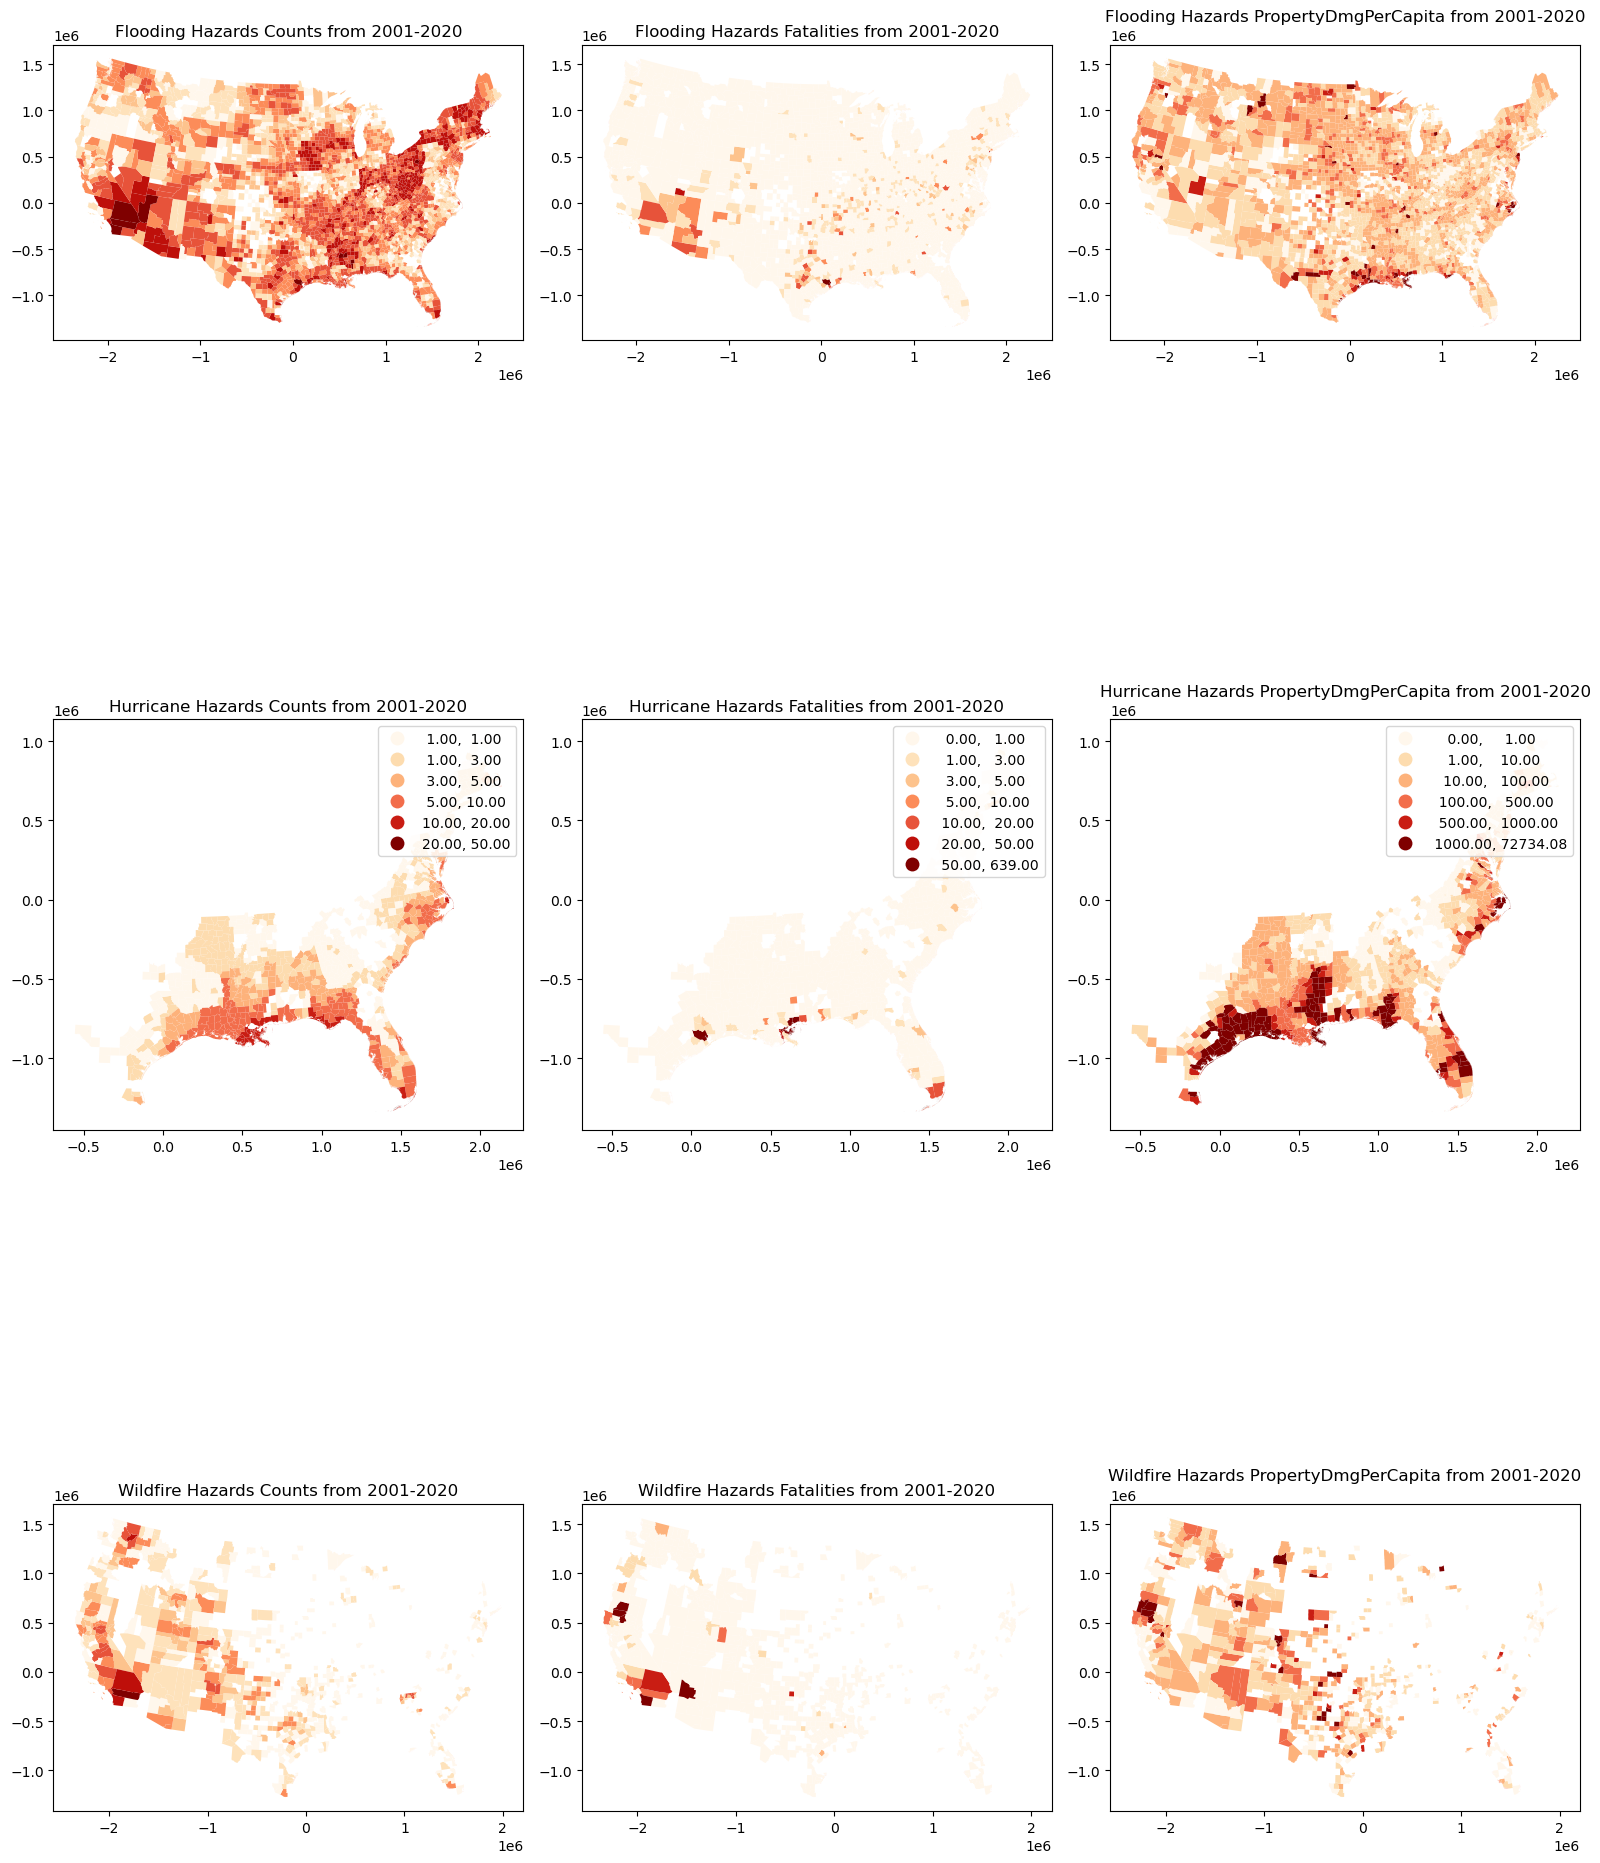

In [130]:
fig, axes = plt.subplots(3,3,figsize=(16,24))
gdf_SHELDUS_20_flooding_county.plot(column="count",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
#                                     scheme="percentiles",
#                                     legend=True,
                                    ax=axes[0,0])
gdf_SHELDUS_20_flooding_county.plot(column="Fatalities",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
#                                     scheme="FisherJenksSampled",
#                                     legend=True,
                                    ax=axes[0,1])
gdf_SHELDUS_20_flooding_county.plot(column="PropertyDmgPerCapita(ADJ 2020)",
                                    scheme='userdefined',classification_kwds={'bins':[1,10,100,500,1000]},
#                                     scheme="percentiles",
                                    cmap="OrRd",
#                                     legend=True,
                                    ax=axes[0,2])

gdf_SHELDUS_20_hurricane_county.plot(column="count",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
#                                     scheme="percentiles",
                                    legend=True,
                                     ax=axes[1,0])
gdf_SHELDUS_20_hurricane_county.plot(column="Fatalities",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
#                                     scheme="FisherJenksSampled",
                                    legend=True,
                                     ax=axes[1,1])
gdf_SHELDUS_20_hurricane_county.plot(column="PropertyDmgPerCapita(ADJ 2020)",
                                    scheme='userdefined',classification_kwds={'bins':[1,10,100,500,1000]},
#                                     scheme="percentiles",
                                    cmap="OrRd",legend=True,ax=axes[1,2])

gdf_SHELDUS_20_wildfire_county.plot(column="count",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
#                                     scheme="percentiles",
#                                     legend=True,
                                    ax=axes[2,0])
gdf_SHELDUS_20_wildfire_county.plot(column="Fatalities",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
#                                     scheme="FisherJenksSampled",
#                                     legend=True,
                                    ax=axes[2,1])
gdf_SHELDUS_20_wildfire_county.plot(column="PropertyDmgPerCapita(ADJ 2020)",
                                    scheme='userdefined',classification_kwds={'bins':[1,10,100,500,1000]},
#                                     scheme="percentiles",
                                    cmap="OrRd",
#                                     legend=True,
                                    ax=axes[2,2])

axes[0,0].set_title("Flooding Hazards Counts from 2001-2020")
axes[1,0].set_title("Hurricane Hazards Counts from 2001-2020")
axes[2,0].set_title("Wildfire Hazards Counts from 2001-2020")

axes[0,1].set_title("Flooding Hazards Fatalities from 2001-2020")
axes[1,1].set_title("Hurricane Hazards Fatalities from 2001-2020")
axes[2,1].set_title("Wildfire Hazards Fatalities from 2001-2020")

axes[0,2].set_title("Flooding Hazards PropertyDmgPerCapita from 2001-2020")
axes[1,2].set_title("Hurricane Hazards PropertyDmgPerCapita from 2001-2020")
axes[2,2].set_title("Wildfire Hazards PropertyDmgPerCapita from 2001-2020")

plt.tight_layout()
plt.show()

In [134]:
df_pep_2010["state"] = df_pep_2010["STATE"].astype('int64').astype('str').str.rjust(2, "0")
df_pep_2010["county"] = df_pep_2010["COUNTY"].astype('int64').astype('str').str.rjust(3, "0")
df_pep_2010["FIPS"] = df_pep_2010["state"] + df_pep_2010["county"]

df_pep_2020["state"] = df_pep_2020["STATE"].astype('int64').astype('str').str.rjust(2, "0")
df_pep_2020["county"] = df_pep_2020["COUNTY"].astype('int64').astype('str').str.rjust(3, "0")
df_pep_2020["FIPS"] = df_pep_2020["state"] + df_pep_2020["county"]

In [135]:
df_pep_0120 = pd.merge(df_pep_2010,df_pep_2020,on="FIPS")

In [137]:
df_pep_0120.to_csv("F:/PEP/est2000-2020-alldata.csv")

In [169]:
correct_netmig_columns = []
for year in range(2001, 2021):
    column_name_x = f'DOMESTICMIG{year}_x'
    column_name_y = f'DOMESTICMIG{year}_y'
    column_name = f'DOMESTICMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns.append(column_name_y)
        
# columns_needed = ['STNAME_x', 'CTYNAME_x', 'CENSUS2000POP', 'CENSUS2010POP'] + correct_netmig_columns
# relevant_data = data[columns_needed]

In [170]:
columns_needed = ['FIPS','STNAME_x', 'CTYNAME_x', 'CENSUS2000POP', 'CENSUS2010POP'] + correct_netmig_columns
relevant_data = df_pep_0120[columns_needed]

In [171]:
relevant_data['CENSUS2010POP'] = relevant_data['CENSUS2010POP'].astype('float')

C:\Users\xiang11\AppData\Local\Temp\ipykernel_24012\3865312276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['CENSUS2010POP'] = relevant_data['CENSUS2010POP'].astype('float')


In [172]:
relevant_data['AveragePopulation'] = (relevant_data['CENSUS2000POP'] + relevant_data['CENSUS2010POP']) / 2
relevant_data['TotalNetMigration'] = relevant_data[correct_netmig_columns].sum(axis=1)
relevant_data['NetMigrationRate'] = (relevant_data['TotalNetMigration'] / relevant_data['AveragePopulation']) * 1000
final_data = relevant_data[['FIPS','STNAME_x', 'CTYNAME_x', 'TotalNetMigration', 'AveragePopulation', 'NetMigrationRate']]

C:\Users\xiang11\AppData\Local\Temp\ipykernel_24012\2021326135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['AveragePopulation'] = (relevant_data['CENSUS2000POP'] + relevant_data['CENSUS2010POP']) / 2
C:\Users\xiang11\AppData\Local\Temp\ipykernel_24012\2021326135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['TotalNetMigration'] = relevant_data[correct_netmig_columns].sum(axis=1)
C:\Users\xiang11\AppData\Local\Temp\ipykernel_24012\2021326135.py:3: SettingWithCopyWarn

In [173]:
df_NMR = pd.merge(final_data,county,on="FIPS",how="inner")
gdf_NMR = gpd.GeoDataFrame(df_NMR,geometry="geometry")

In [176]:
# gdf_NMR.sort_values(by="NetMigrationRate",ascending=False)

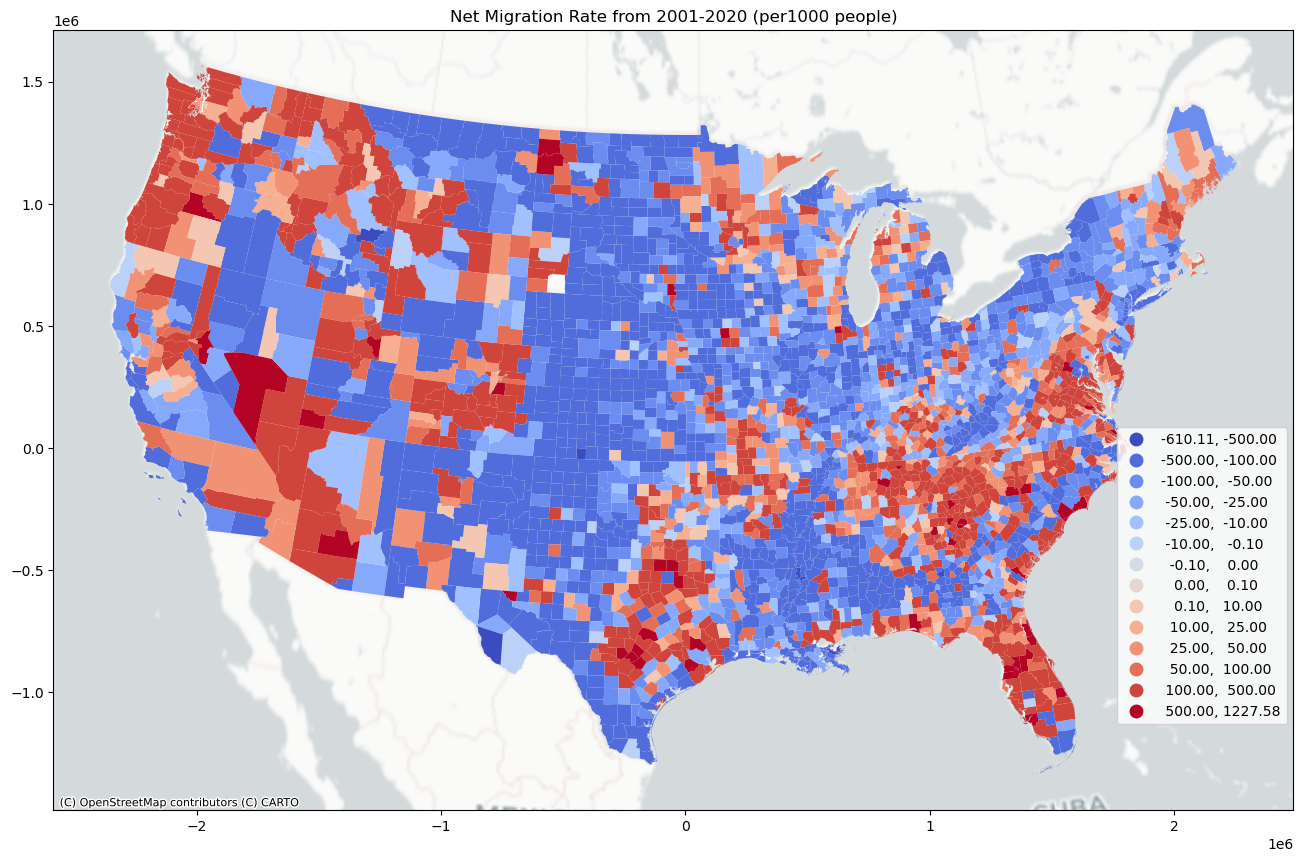

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))
gdf_NMR.plot(column="NetMigrationRate",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=ax)
leg = ax.get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
ax.set_title("Net Migration Rate from 2001-2020 (per1000 people)")
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=gdf_NMR.crs)

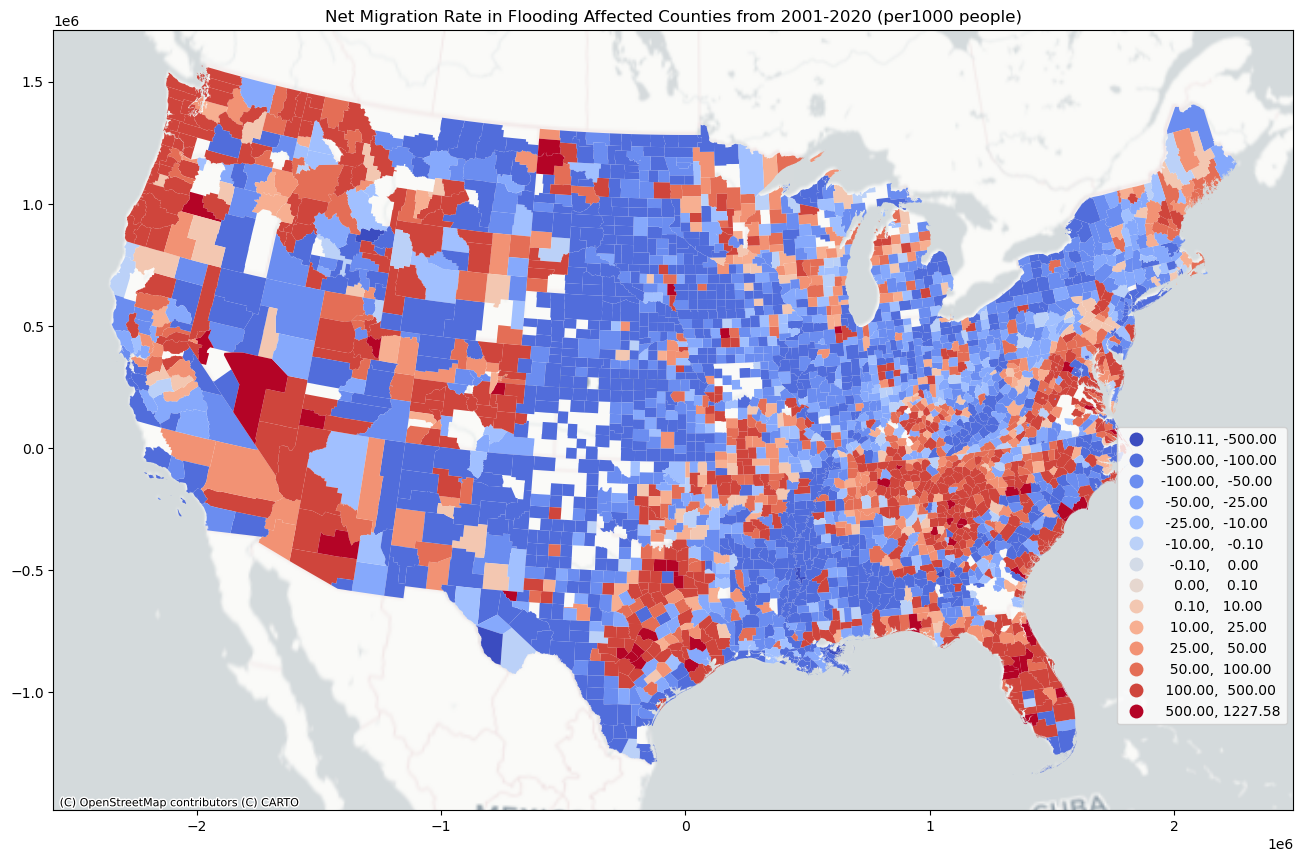

In [210]:
gdf_NMR_flooding = gdf_NMR[gdf_NMR["FIPS"].isin(SHELDUS_flooding_county)].reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(16, 20))
gdf_NMR_flooding.plot(column="NetMigrationRate",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=ax)
leg = ax.get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
ax.set_title("Net Migration Rate in Flooding Affected Counties from 2001-2020 (per1000 people)")
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=gdf_NMR.crs)

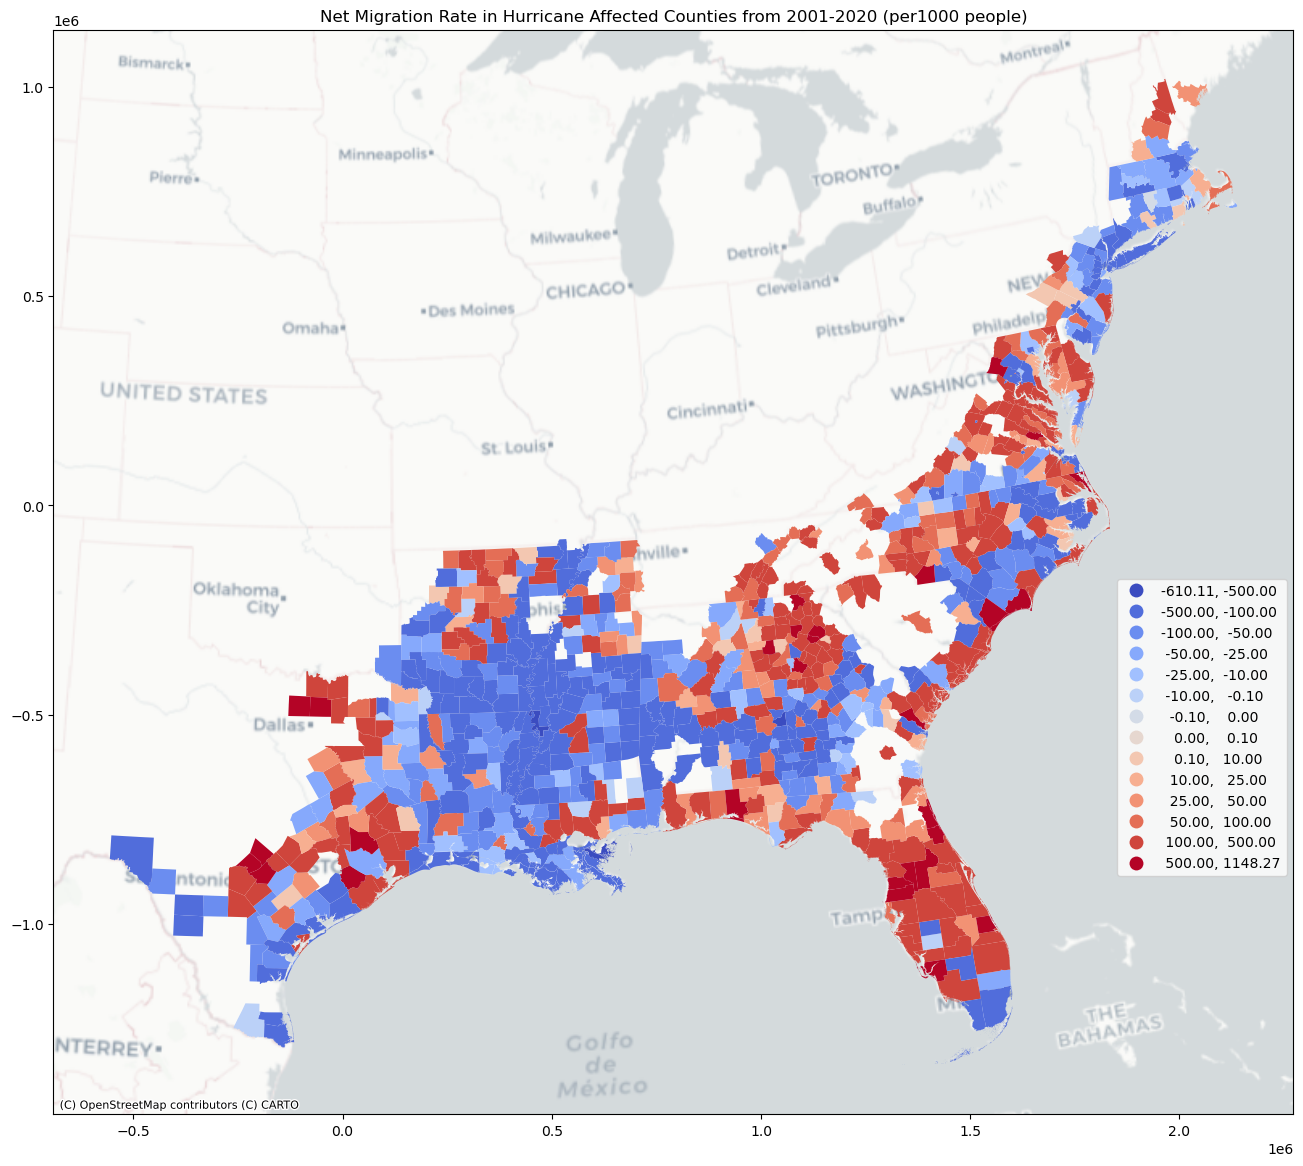

In [211]:
gdf_NMR_hurricane = gdf_NMR[gdf_NMR["FIPS"].isin(SHELDUS_hurricane_county)].reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(16, 20))
gdf_NMR_hurricane.plot(column="NetMigrationRate",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=ax)
leg = ax.get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
ax.set_title("Net Migration Rate in Hurricane Affected Counties from 2001-2020 (per1000 people)")
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=gdf_NMR.crs)

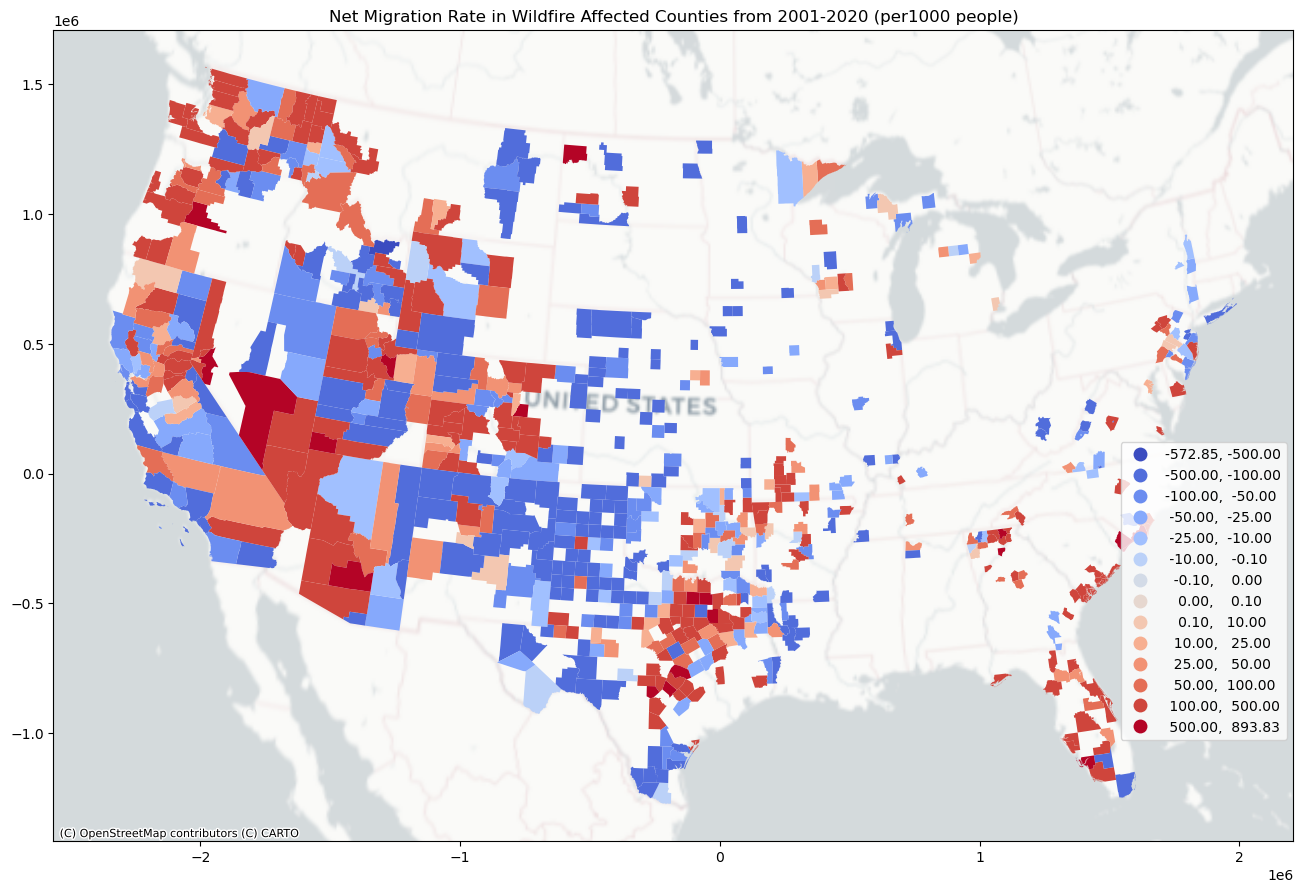

In [212]:
gdf_NMR_wildfire = gdf_NMR[gdf_NMR["FIPS"].isin(SHELDUS_wildfire_county)].reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(16, 20))
gdf_NMR_wildfire.plot(column="NetMigrationRate",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=ax)
leg = ax.get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
ax.set_title("Net Migration Rate in Wildfire Affected Counties from 2001-2020 (per1000 people)")
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=gdf_NMR.crs)

In [213]:
NMR= [gdf_NMR.NetMigrationRate.mean(),gdf_NMR.NetMigrationRate.min(),gdf_NMR.NetMigrationRate.max(),gdf_NMR.NetMigrationRate.std()]
NMR_f= [gdf_NMR_flooding.NetMigrationRate.mean(),gdf_NMR_flooding.NetMigrationRate.min(),gdf_NMR_flooding.NetMigrationRate.max(),gdf_NMR_flooding.NetMigrationRate.std()]
NMR_h= [gdf_NMR_hurricane.NetMigrationRate.mean(),gdf_NMR_hurricane.NetMigrationRate.min(),gdf_NMR_hurricane.NetMigrationRate.max(),gdf_NMR_hurricane.NetMigrationRate.std()]
NMR_w= [gdf_NMR_wildfire.NetMigrationRate.mean(),gdf_NMR_wildfire.NetMigrationRate.min(),gdf_NMR_wildfire.NetMigrationRate.max(),gdf_NMR_wildfire.NetMigrationRate.std()]

count_f = [gdf_SHELDUS_20_flooding_county["count"].mean(),gdf_SHELDUS_20_flooding_county["count"].min(),gdf_SHELDUS_20_flooding_county["count"].max(),gdf_SHELDUS_20_flooding_county["count"].std()]
count_h = [gdf_SHELDUS_20_hurricane_county["count"].mean(),gdf_SHELDUS_20_hurricane_county["count"].min(),gdf_SHELDUS_20_hurricane_county["count"].max(),gdf_SHELDUS_20_hurricane_county["count"].std()]
count_w = [gdf_SHELDUS_20_wildfire_county["count"].mean(),gdf_SHELDUS_20_wildfire_county["count"].min(),gdf_SHELDUS_20_wildfire_county["count"].max(),gdf_SHELDUS_20_wildfire_county["count"].std()]

In [225]:
floodingFips = list(gdf_NMR_flooding.FIPS)
gdf_SHELDUS_20_flooding_county = gdf_SHELDUS_20_flooding_county[gdf_SHELDUS_20_flooding_county["County FIPS"].isin(floodingFips)].reset_index(drop=True)

In [232]:
X_f =  gdf_SHELDUS_20_flooding_county[["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]]
Y_f =  gdf_NMR_flooding["NetMigrationRate"]

X_f = sm.add_constant(X_f)
model = sm.OLS(Y_f, X_f).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       NetMigrationRate   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 04 Jul 2024   Prob (F-statistic):                nan
Time:                        19:14:09   Log-Likelihood:                    nan
No. Observations:                2935   AIC:                               nan
Df Residuals:                    2930   BIC:                               nan
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [217]:
X_h =  gdf_SHELDUS_20_hurricane_county[["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]]
Y_h =  gdf_NMR_hurricane["NetMigrationRate"]

X_h = sm.add_constant(X_h)
model = sm.OLS(Y_h, X_h).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       NetMigrationRate   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.667
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           0.000989
Time:                        19:07:06   Log-Likelihood:                -5876.0
No. Observations:                 869   AIC:                         1.176e+04
Df Residuals:                     864   BIC:                         1.179e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [234]:
X_w =  gdf_SHELDUS_20_wildfire_county[["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]]
Y_w =  gdf_NMR_wildfire["NetMigrationRate"]

X_w = sm.add_constant(X_w)
model = sm.OLS(Y_w, X_w).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       NetMigrationRate   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 04 Jul 2024   Prob (F-statistic):                nan
Time:                        19:15:19   Log-Likelihood:                    nan
No. Observations:                 667   AIC:                               nan
Df Residuals:                     662   BIC:                               nan
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

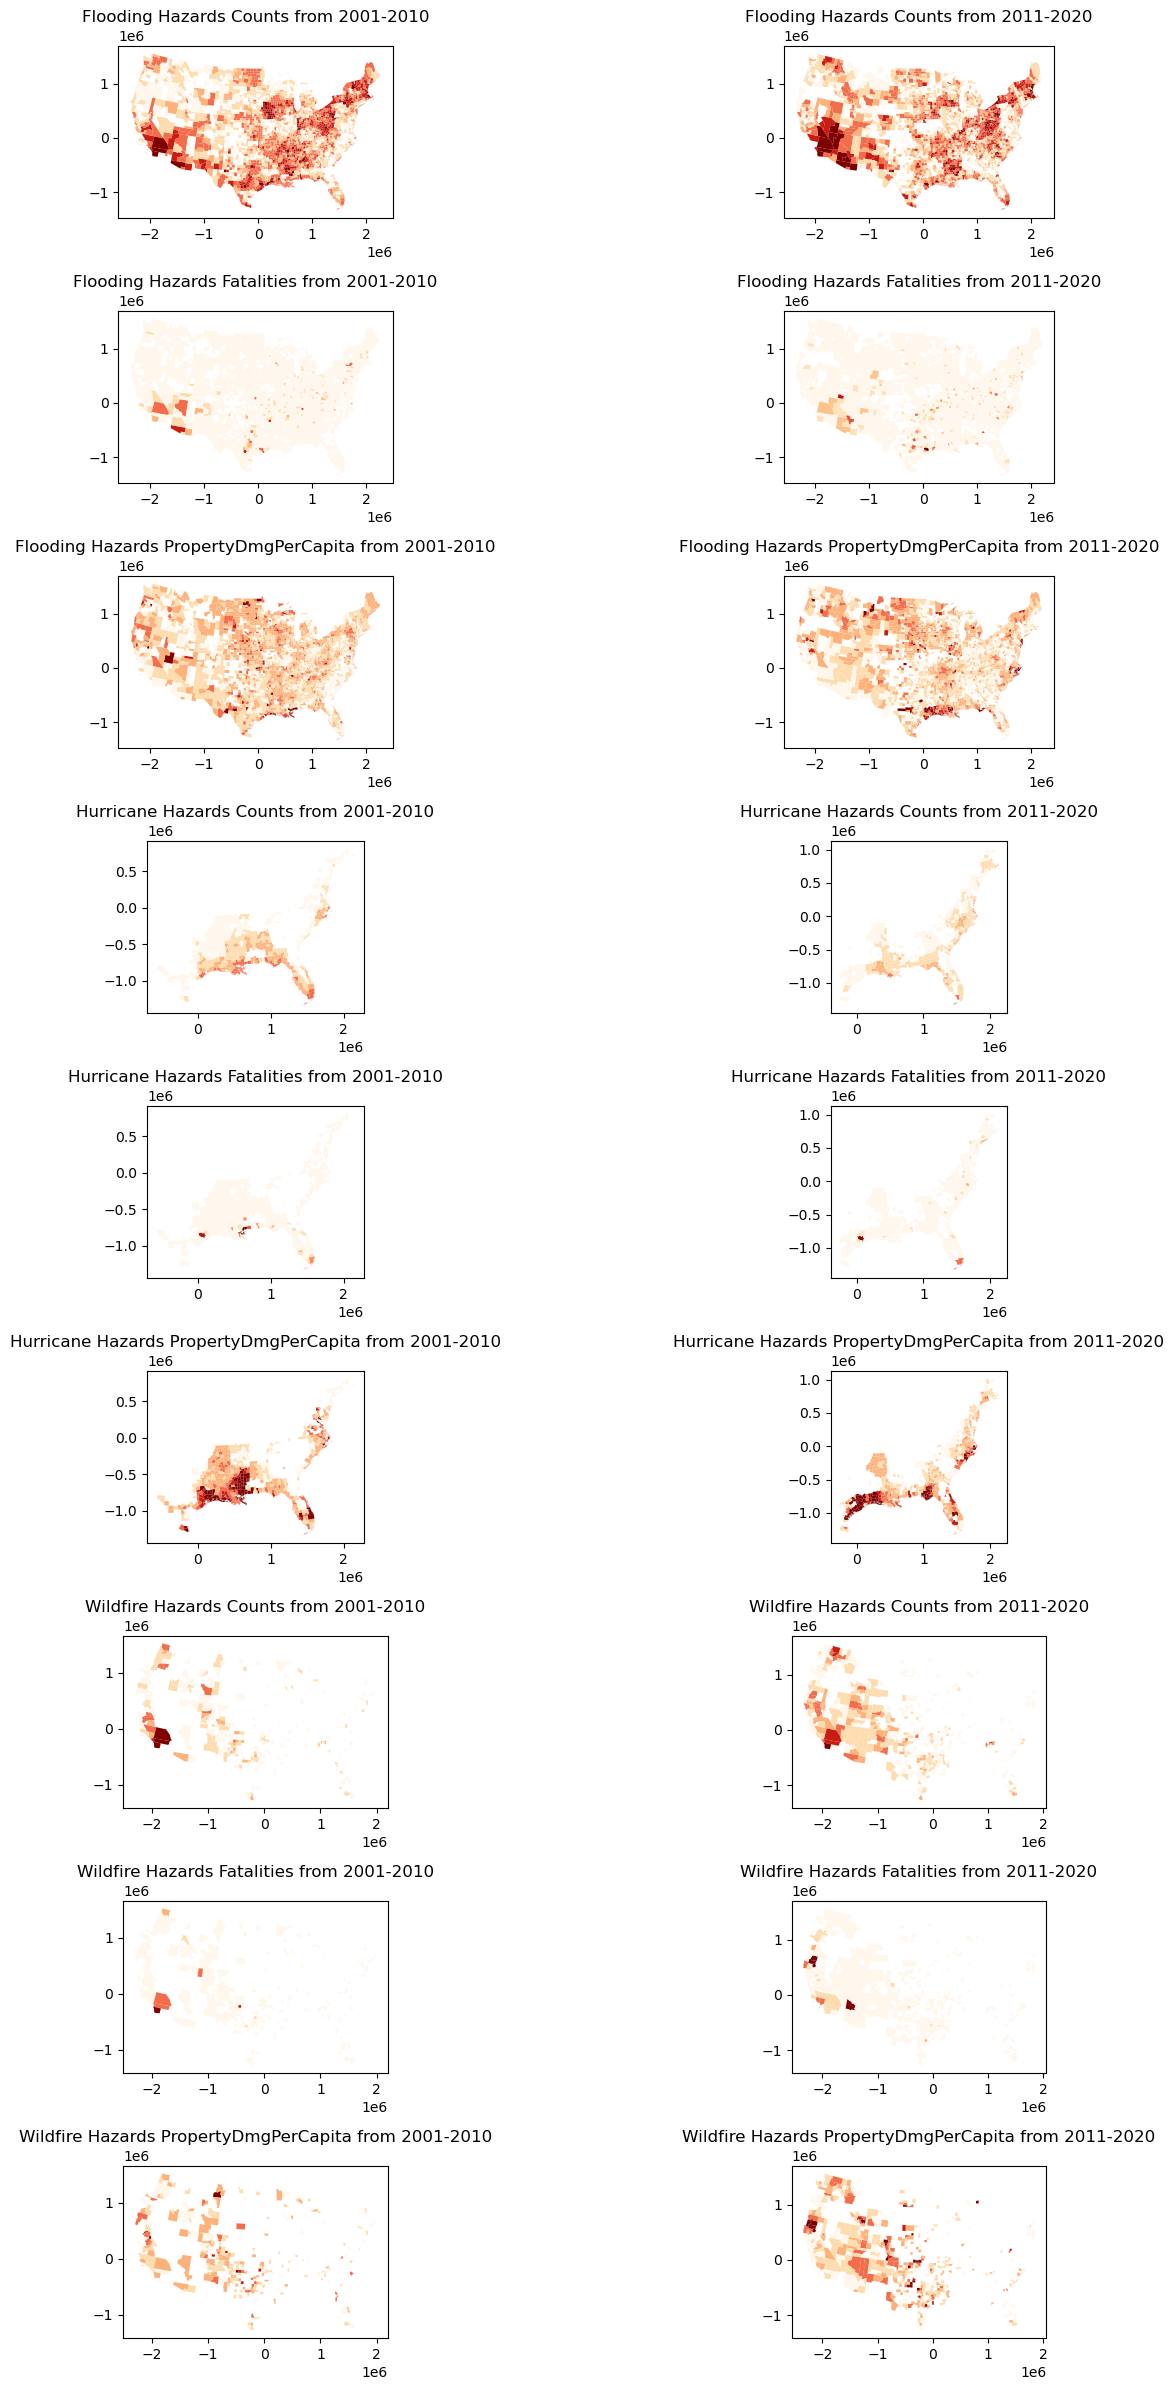

In [246]:
fig, axes = plt.subplots(9,2,figsize=(16,24))
i=0
for decade in ["2001-2010","2011-2020"]:
    gdf_SHELDUS_10_flooding_county_use = gdf_SHELDUS_10_flooding_county[gdf_SHELDUS_10_flooding_county["decade"]==str(decade)]
    gdf_SHELDUS_10_flooding_county_use.plot(column="count",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
                                    ax=axes[0,i])
    gdf_SHELDUS_10_flooding_county_use.plot(column="Fatalities",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
                                    ax=axes[1,i])
    gdf_SHELDUS_10_flooding_county_use.plot(column="PropertyDmgPerCapita(ADJ 2020)",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,10,100,500,1000]},
                                    ax=axes[2,i])
    axes[0,i].set_title(f"Flooding Hazards Counts from {decade}")
    axes[1,i].set_title(f"Flooding Hazards Fatalities from {decade}")
    axes[2,i].set_title(f"Flooding Hazards PropertyDmgPerCapita from {decade}")
    
    gdf_SHELDUS_10_hurricane_county_use = gdf_SHELDUS_10_hurricane_county[gdf_SHELDUS_10_hurricane_county["decade"]==str(decade)]
    gdf_SHELDUS_10_hurricane_county_use.plot(column="count",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
                                    ax=axes[3,i])
    gdf_SHELDUS_10_hurricane_county_use.plot(column="Fatalities",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
                                    ax=axes[4,i])
    gdf_SHELDUS_10_hurricane_county_use.plot(column="PropertyDmgPerCapita(ADJ 2020)",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,10,100,500,1000]},
                                    ax=axes[5,i])
    axes[3,i].set_title(f"Hurricane Hazards Counts from {decade}")
    axes[4,i].set_title(f"Hurricane Hazards Fatalities from {decade}")
    axes[5,i].set_title(f"Hurricane Hazards PropertyDmgPerCapita from {decade}")    
    
    gdf_SHELDUS_10_wildfire_county_use = gdf_SHELDUS_10_wildfire_county[gdf_SHELDUS_10_wildfire_county["decade"]==str(decade)]
    gdf_SHELDUS_10_wildfire_county_use.plot(column="count",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
                                    ax=axes[6,i])
    gdf_SHELDUS_10_wildfire_county_use.plot(column="Fatalities",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,3,5,10,20,50]},
                                    ax=axes[7,i])
    gdf_SHELDUS_10_wildfire_county_use.plot(column="PropertyDmgPerCapita(ADJ 2020)",cmap="OrRd",
                                    scheme='userdefined',classification_kwds={'bins':[1,10,100,500,1000]},
                                    ax=axes[8,i])
    axes[6,i].set_title(f"Wildfire Hazards Counts from {decade}")
    axes[7,i].set_title(f"Wildfire Hazards Fatalities from {decade}")
    axes[8,i].set_title(f"Wildfire Hazards PropertyDmgPerCapita from {decade}")    
    
    i=i+1

plt.tight_layout()
plt.show()

In [267]:
correct_netmig_columns1 = []
for year in range(2001, 2011):
    column_name_x = f'DOMESTICMIG{year}_x'
    column_name_y = f'DOMESTICMIG{year}_y'
    column_name = f'DOMESTICMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns1.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns1.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns1.append(column_name_y)
correct_netmig_columns2 = []
for year in range(2011, 2021):
    column_name_x = f'DOMESTICMIG{year}_x'
    column_name_y = f'DOMESTICMIG{year}_y'
    column_name = f'DOMESTICMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns2.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns2.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns2.append(column_name_y)

In [275]:
columns_needed1 = ['FIPS','STNAME_x', 'CTYNAME_x', 'CENSUS2000POP','CENSUS2010POP'] + correct_netmig_columns1 + correct_netmig_columns2
relevant_data = df_pep_0120[columns_needed1]
relevant_data['CENSUS2010POP'] = relevant_data['CENSUS2010POP'].astype('float')

C:\Users\xiang11\AppData\Local\Temp\ipykernel_24012\700877619.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['CENSUS2010POP'] = relevant_data['CENSUS2010POP'].astype('float')


In [277]:
relevant_data['AveragePopulation01_10'] = relevant_data['CENSUS2000POP']
relevant_data['TotalNetMigration01_10'] = relevant_data[correct_netmig_columns1].sum(axis=1)
relevant_data['NetMigrationRate01_10'] = (relevant_data['TotalNetMigration01_10'] / relevant_data['AveragePopulation01_10']) * 1000


relevant_data['AveragePopulation11_20'] = relevant_data['CENSUS2010POP']
relevant_data['TotalNetMigration11_20'] = relevant_data[correct_netmig_columns2].sum(axis=1)
relevant_data['NetMigrationRate11_20'] = (relevant_data['TotalNetMigration11_20'] / relevant_data['AveragePopulation11_20']) * 1000
final_data = relevant_data[['FIPS','STNAME_x', 'CTYNAME_x', 'TotalNetMigration01_10', 'AveragePopulation01_10', 'NetMigrationRate01_10','TotalNetMigration11_20', 'AveragePopulation11_20', 'NetMigrationRate11_20']]


C:\Users\xiang11\AppData\Local\Temp\ipykernel_24012\99142455.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['AveragePopulation01_10'] = relevant_data['CENSUS2000POP']
C:\Users\xiang11\AppData\Local\Temp\ipykernel_24012\99142455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['TotalNetMigration01_10'] = relevant_data[correct_netmig_columns1].sum(axis=1)
C:\Users\xiang11\AppData\Local\Temp\ipykernel_24012\99142455.py:3: SettingWithCopyWarning: 
A value is trying to be set 

In [278]:
df_NMR_2 = pd.merge(final_data,county,on="FIPS",how="inner")
gdf_NMR_2 = gpd.GeoDataFrame(df_NMR_2,geometry="geometry")

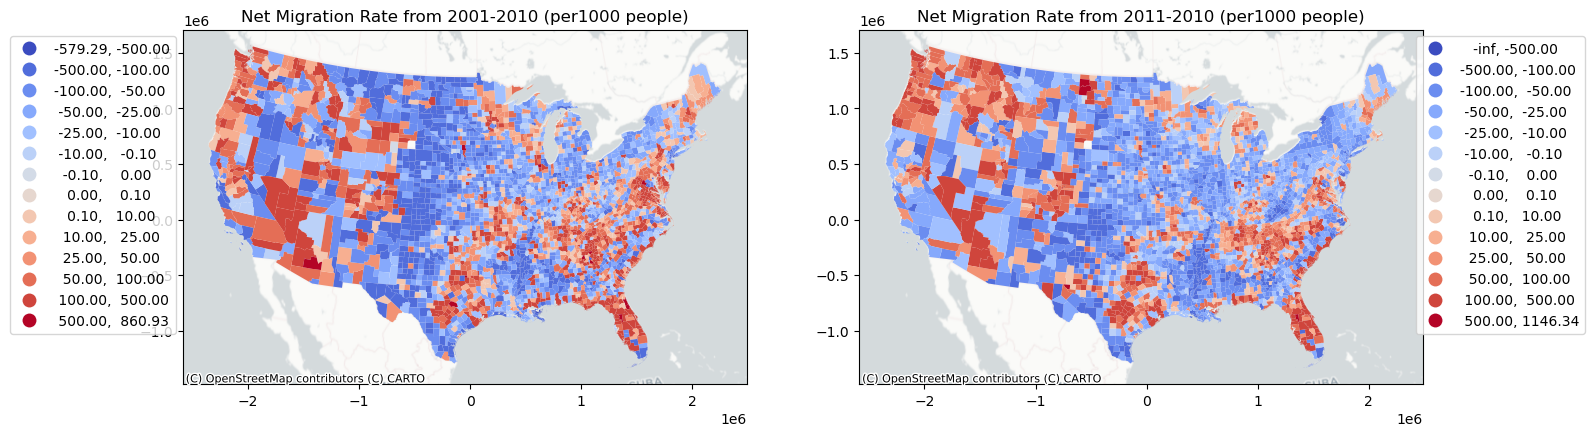

In [286]:
fig, axes = plt.subplots(1, 2, figsize=(16, 20))
gdf_NMR_2.plot(column="NetMigrationRate01_10",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[0])
leg = axes[0].get_legend()
leg.set_bbox_to_anchor((0,1)) 
axes[0].set_title("Net Migration Rate from 2001-2010 (per1000 people)")
cx.add_basemap(ax=axes[0], source=cx.providers.CartoDB.Positron, crs=gdf_NMR.crs)
gdf_NMR_2.plot(column="NetMigrationRate11_20",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[1])
leg = axes[1].get_legend()
leg.set_bbox_to_anchor(( 1.3,1)) 
axes[1].set_title("Net Migration Rate from 2011-2010 (per1000 people)")
cx.add_basemap(ax=axes[1], source=cx.providers.CartoDB.Positron, crs=gdf_NMR.crs)

In [289]:
conditions1 = [
    (gdf_NMR_2["NetMigrationRate01_10"]>0)&(gdf_NMR_2["NetMigrationRate11_20"]>0),
    (gdf_NMR_2["NetMigrationRate01_10"]<0)&(gdf_NMR_2["NetMigrationRate11_20"]<0),
    (gdf_NMR_2["NetMigrationRate01_10"]>0)&(gdf_NMR_2["NetMigrationRate11_20"]<0),
    (gdf_NMR_2["NetMigrationRate01_10"]<0)&(gdf_NMR_2["NetMigrationRate11_20"]>0),
]

choices1 = ["Gain Continue","Loss Continue", "Gain then Loss", "Loss then Gain"]

gdf_NMR_2['Migration'] = np.select(conditions1, choices1, default=np.nan)

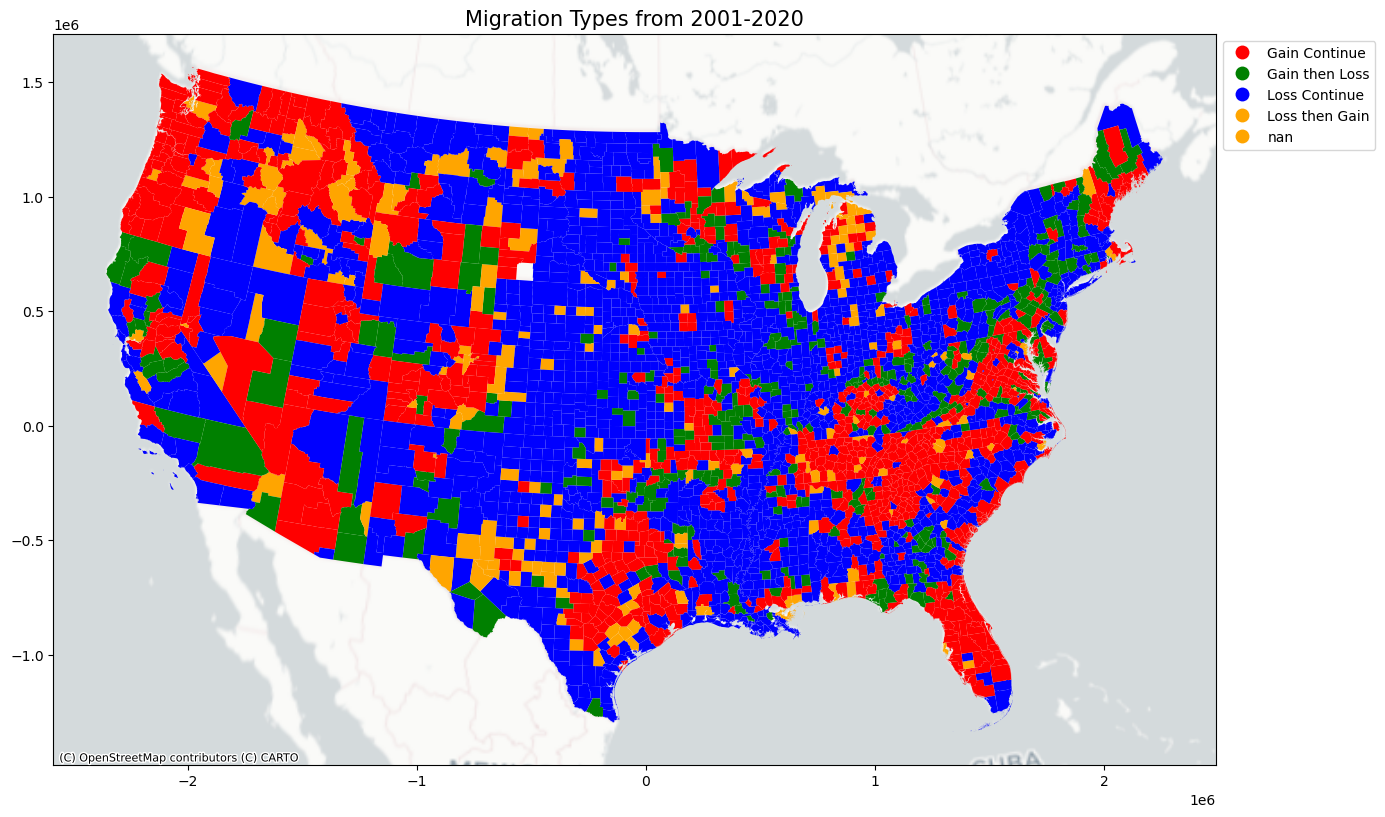

In [303]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

colors = ['red', 'green', 'blue', 'orange']  # Adjust the colors as needed
cmap = ListedColormap(colors)

# Plotting the different migration types
gdf_NMR_2.plot(column='Migration', categorical=True, legend=True, 
               cmap=cmap, ax=ax, legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'})

# Add a title
ax.set_title('Migration Types from 2001-2020', fontsize=15)

# Add a basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=gdf_NMR_2.crs)

# Display the plot
plt.show()

In [305]:
SHELDUS_10_use_flooding_0110 = SHELDUS_10_use_flooding[SHELDUS_10_use_flooding["decade"]=="2001-2010"]
SHELDUS_flooding_0110_list = list(SHELDUS_10_use_flooding_0110["County FIPS"])

SHELDUS_10_use_flooding_1120 = SHELDUS_10_use_flooding[SHELDUS_10_use_flooding["decade"]=="2011-2020"]
SHELDUS_flooding_1120_list = list(SHELDUS_10_use_flooding_1120["County FIPS"])

SHELDUS_10_use_hurricane_0110 = SHELDUS_10_use_hurricane[SHELDUS_10_use_hurricane["decade"]=="2001-2010"]
SHELDUS_hurricane_0110_list = list(SHELDUS_10_use_hurricane_0110["County FIPS"])

SHELDUS_10_use_hurricane_1120 = SHELDUS_10_use_hurricane[SHELDUS_10_use_hurricane["decade"]=="2011-2020"]
SHELDUS_hurricane_1120_list = list(SHELDUS_10_use_hurricane_1120["County FIPS"])

SHELDUS_10_use_wildfire_0110 = SHELDUS_10_use_wildfire[SHELDUS_10_use_wildfire["decade"]=="2001-2010"]
SHELDUS_wildfire_0110_list = list(SHELDUS_10_use_wildfire_0110["County FIPS"])

SHELDUS_10_use_wildfire_1120 = SHELDUS_10_use_wildfire[SHELDUS_10_use_wildfire["decade"]=="2011-2020"]
SHELDUS_wildfire_1120_list = list(SHELDUS_10_use_wildfire_1120["County FIPS"])

In [308]:
gdf_NMR_flooding_0110  = gdf_NMR_2[gdf_NMR_2["FIPS"].isin(SHELDUS_flooding_0110_list)]
gdf_NMR_flooding_1120  = gdf_NMR_2[gdf_NMR_2["FIPS"].isin(SHELDUS_flooding_1120_list)]
gdf_NMR_hurricane_0110 = gdf_NMR_2[gdf_NMR_2["FIPS"].isin(SHELDUS_hurricane_0110_list)]
gdf_NMR_hurricane_1120 = gdf_NMR_2[gdf_NMR_2["FIPS"].isin(SHELDUS_hurricane_1120_list)]
gdf_NMR_wildfire_0110  = gdf_NMR_2[gdf_NMR_2["FIPS"].isin(SHELDUS_wildfire_0110_list)]
gdf_NMR_wildfire_1120  = gdf_NMR_2[gdf_NMR_2["FIPS"].isin(SHELDUS_wildfire_1120_list)]

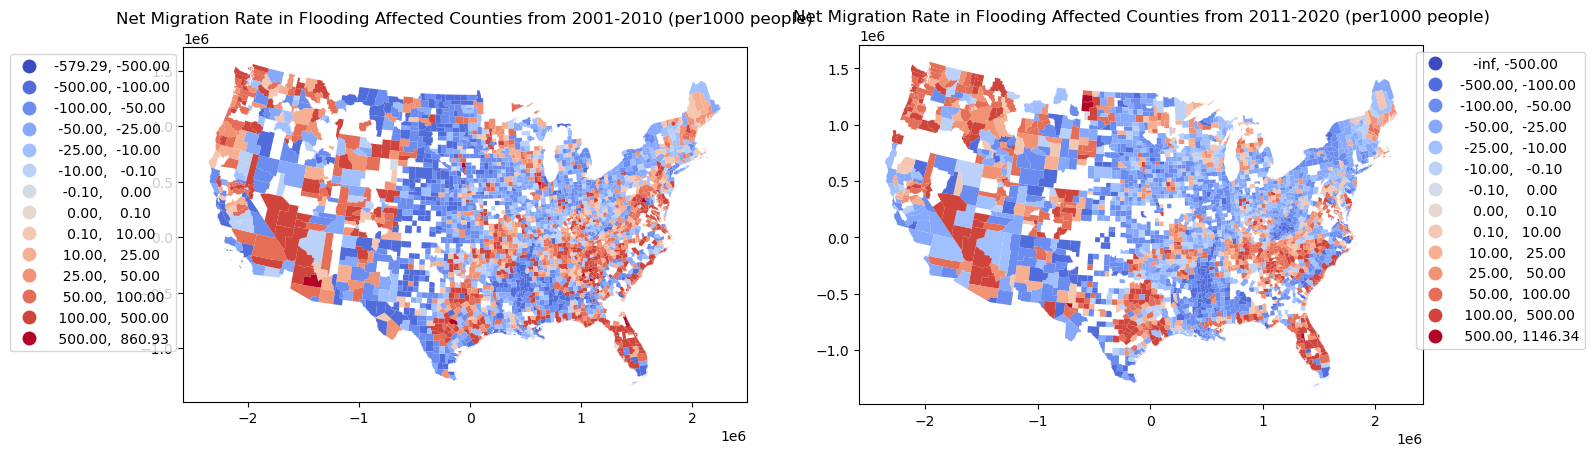

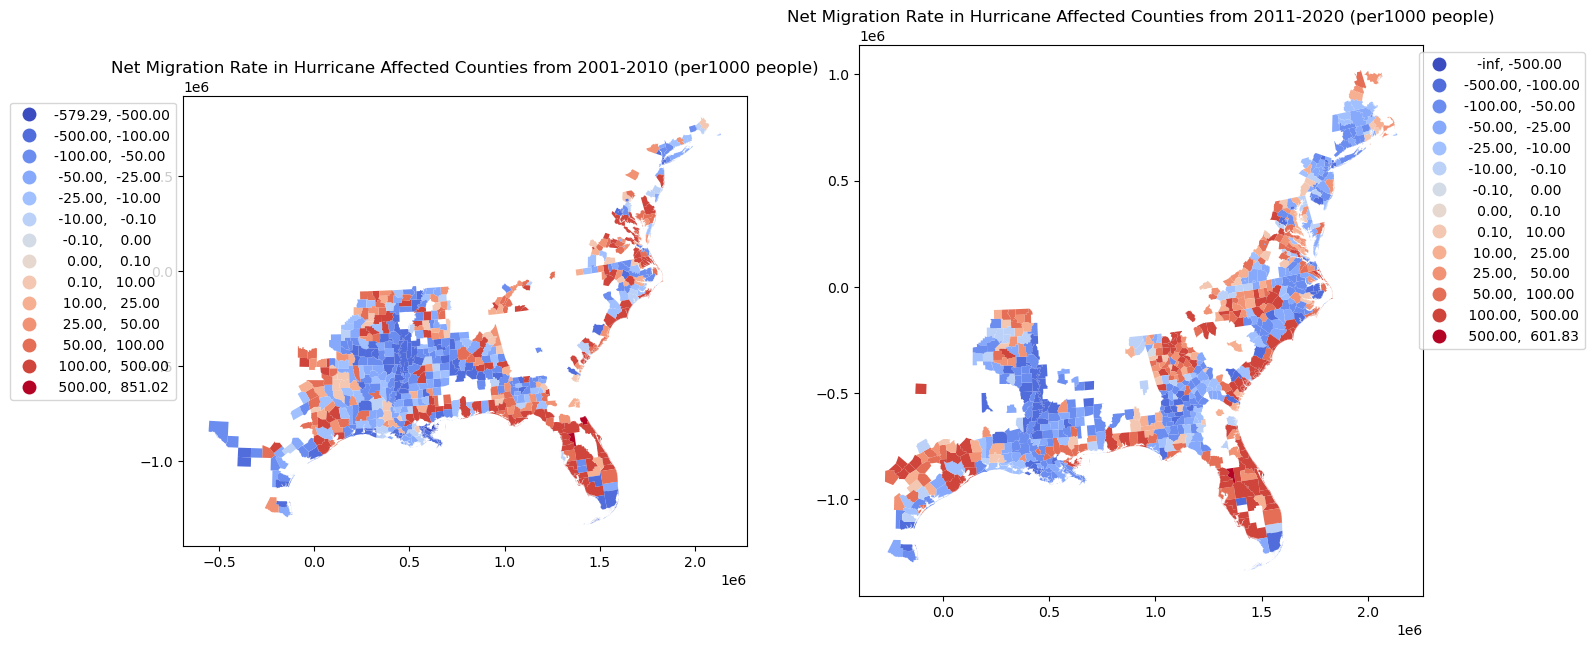

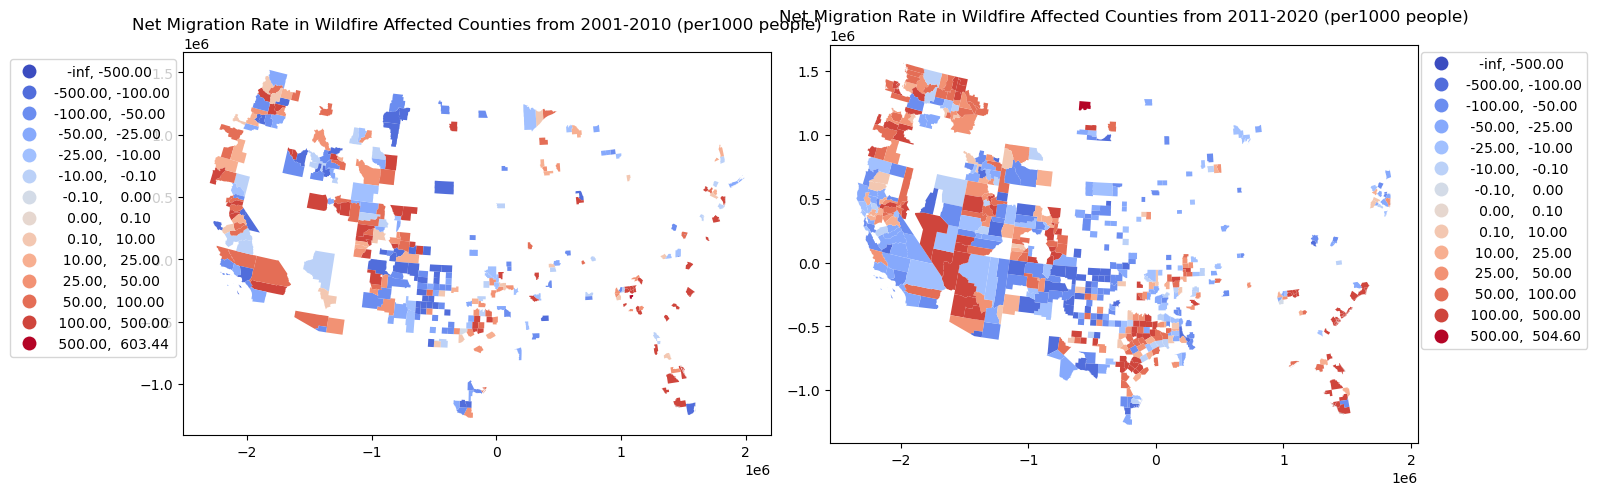

In [317]:
fig, axes = plt.subplots(1,2,figsize=(16,24))

gdf_NMR_flooding_0110.plot(column="NetMigrationRate01_10",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[0], legend_kwds={'bbox_to_anchor': (0, 1)})
gdf_NMR_flooding_1120.plot(column="NetMigrationRate11_20",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[1], legend_kwds={'bbox_to_anchor': (1.3, 1)})
axes[0].set_title("Net Migration Rate in Flooding Affected Counties from 2001-2010 (per1000 people)")
axes[1].set_title("Net Migration Rate in Flooding Affected Counties from 2011-2020 (per1000 people)")

fig, axes = plt.subplots(1,2,figsize=(16,24))
gdf_NMR_hurricane_0110.plot(column="NetMigrationRate01_10",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[0], legend_kwds={'bbox_to_anchor': (0, 1)})
gdf_NMR_hurricane_1120.plot(column="NetMigrationRate11_20",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[1], legend_kwds={'bbox_to_anchor': (1.3, 1)})
axes[0].set_title("Net Migration Rate in Hurricane Affected Counties from 2001-2010 (per1000 people)")
axes[1].set_title("Net Migration Rate in Hurricane Affected Counties from 2011-2020 (per1000 people)")

fig, axes = plt.subplots(1,2,figsize=(16,24))
gdf_NMR_wildfire_0110.plot(column="NetMigrationRate01_10",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[0], legend_kwds={'bbox_to_anchor': (0, 1)})
gdf_NMR_wildfire_1120.plot(column="NetMigrationRate11_20",cmap="coolwarm",
             scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[1], legend_kwds={'bbox_to_anchor': (1.3, 1)})
axes[0].set_title("Net Migration Rate in Wildfire Affected Counties from 2001-2010 (per1000 people)")
axes[1].set_title("Net Migration Rate in Wildfire Affected Counties from 2011-2020 (per1000 people)")

plt.tight_layout()
plt.show()

In [323]:
flooding_0110 = pd.merge(gdf_NMR_flooding_0110,SHELDUS_10_use_flooding_0110,left_on="FIPS",right_on="County FIPS",how="inner")
flooding_1120 = pd.merge(gdf_NMR_flooding_1120,SHELDUS_10_use_flooding_1120,left_on="FIPS",right_on="County FIPS",how="inner")

hurricane_0110 = pd.merge(gdf_NMR_hurricane_0110,SHELDUS_10_use_hurricane_0110,left_on="FIPS",right_on="County FIPS",how="inner")
hurricane_1120 = pd.merge(gdf_NMR_hurricane_1120,SHELDUS_10_use_hurricane_1120,left_on="FIPS",right_on="County FIPS",how="inner")

wildfire_0110 = pd.merge(gdf_NMR_wildfire_0110,SHELDUS_10_use_wildfire_0110,left_on="FIPS",right_on="County FIPS",how="inner")
wildfire_1120 = pd.merge(gdf_NMR_wildfire_1120,SHELDUS_10_use_wildfire_1120,left_on="FIPS",right_on="County FIPS",how="inner")

In [332]:
X_f_1 =  flooding_0110[["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]]
Y_f_1 =  flooding_0110["NetMigrationRate01_10"]

X_f_1 = sm.add_constant(X_f_1)
model1 = sm.OLS(Y_f_1, X_f_1).fit()

X_f_2 =  flooding_1120[["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]]
Y_f_2 =  flooding_1120["NetMigrationRate11_20"]

X_f_2 = sm.add_constant(X_f_2)
model2 = sm.OLS(Y_f_2, X_f_2).fit()
print(model1.summary())
print(model2.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRate01_10   R-squared:                       0.015
Model:                               OLS   Adj. R-squared:                  0.014
Method:                    Least Squares   F-statistic:                     10.47
Date:                   Fri, 05 Jul 2024   Prob (F-statistic):           2.05e-08
Time:                           10:12:46   Log-Likelihood:                -16354.
No. Observations:                   2677   AIC:                         3.272e+04
Df Residuals:                       2672   BIC:                         3.275e+04
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [333]:
X_h_1 =  hurricane_0110[["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]]
Y_h_1 =  hurricane_0110["NetMigrationRate01_10"]

X_h_1 = sm.add_constant(X_h_1)
model1 = sm.OLS(Y_h_1, X_h_1).fit()

X_h_2 =  hurricane_1120[["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]]
Y_h_2 =  hurricane_1120["NetMigrationRate11_20"]

X_h_2 = sm.add_constant(X_h_2)
model2 = sm.OLS(Y_h_2, X_h_2).fit()
print(model1.summary())
print(model2.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRate01_10   R-squared:                       0.057
Model:                               OLS   Adj. R-squared:                  0.050
Method:                    Least Squares   F-statistic:                     8.818
Date:                   Fri, 05 Jul 2024   Prob (F-statistic):           6.43e-07
Time:                           10:12:47   Log-Likelihood:                -3693.2
No. Observations:                    593   AIC:                             7396.
Df Residuals:                        588   BIC:                             7418.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [334]:
X_w_1 =  wildfire_0110[["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]]
Y_w_1 =  wildfire_0110["NetMigrationRate01_10"]

X_w_1 = sm.add_constant(X_w_1)
model1 = sm.OLS(Y_w_1, X_w_1).fit()

X_w_2 =  wildfire_1120[["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]]
Y_w_2 =  wildfire_1120["NetMigrationRate11_20"]

X_w_2 = sm.add_constant(X_w_2)
model2 = sm.OLS(Y_w_2, X_w_2).fit()
print(model1.summary())
print(model2.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRate01_10   R-squared:                       0.024
Model:                               OLS   Adj. R-squared:                  0.012
Method:                    Least Squares   F-statistic:                     1.968
Date:                   Fri, 05 Jul 2024   Prob (F-statistic):             0.0991
Time:                           10:12:47   Log-Likelihood:                -2010.4
No. Observations:                    326   AIC:                             4031.
Df Residuals:                        321   BIC:                             4050.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

Social vulnerability
1) index
2) social vulnerability,hazards,net migration
3) Find coastal counties for hurricane
hierarchical regression
ACS in notion

climate gentrification

### Link different disaster (hard)
### Easier way, relation between population netflow and frequency disaster
move in or move out

dynamic time line
breakdown net population migration in high middle low level

different disaster level,